## OCNS 2019, Simulating dendrites at different levels of abstraction.
## Exercise 1c: Integrating inputs with active dendritic conductances
### In this exercise we will see how inputs can be amplified by active sodium conductances

### compile ion channel models (.mod files)

In [1]:
%%bash
nrnivmodl  # Compile NEURON model (for Linux/Mac users)
# For windows users: type "mknrndll" in the start menu and navigate to the folder with the .mod files and press enter.

/Users/wfpodlaski/Dropbox/Code/ocns2019_simulatingdendrites
Traub.mod h.mod ka.mod
Traub.mod h.mod ka.mod
"/Applications/NEURON-7.7/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/Applications/NEURON-7.7/nrn/include/nrn" -I"/Applications/NEURON-7.7/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/Applications/NEURON-7.7/nrn/include/nrn -I/Applications/NEURON-7.7/nrn/x86_64/lib -g -O2 -c mod_func.c  -fno-common -DPIC -o .libs/mod_func.o
"/Applications/NEURON-7.7/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -headerpad_max_install_names -o libnrnmech.la -rpath "/Applications/NEURON-7.7/nrn/x86_64/lib"  Traub.lo h.lo ka.lo mod_func.lo  -L"/Applications/NEURON-7.7/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -L"/Applications/NEURON-7.7/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       
libtool: link: rm -fr  .libs/libnrn

In [2]:
# -*- coding: utf-8 -*-
from neuron import h, gui
from matplotlib import pyplot as plt
% matplotlib inline

# Simulation parameters
h.tstop = 100               # ms
h.dt = 0.1                  # ms
h.steps_per_ms = 10         # For plotting-should be compartible with dt
h.v_init = -65              # initial membrane potential
fs = 14                     # font size for plots

### Create a soma and two dendrites, define their anatomical and biophysical properties and connect them.

In [3]:
# Create a soma and two dendrites and connect them.
soma=h.Section(name='soma')
dend0, dend1 = [h.Section(name=n) for n in ['dend0', 'dend1']]

# Define properties of soma
soma.diam = 20        # um
soma.L = 200          # um
soma.Ra = 100         # Axial resistance in Ohm * cm
soma.cm = 1           # specific membrane capacitance, capacitance per unit of membrane, uF/cm^2   
soma.nseg = 1         # number of segments (spatial grid)

# Insert only passive conductance into soma (in contrast to previous two exercises)    
soma.insert('pas')
for seg in soma: 
    seg.pas.e= -65        # Reversal potential in mV
    seg.pas.g= 0.0003     # Leak conductance in S/cm2

# Define properties of dend0
dend0.diam = 5
dend0.L = 500
dend0.nseg=11
dend0.cm = 1
dend0.Ra = 100

# Insert passive conductance into dend0
dend0.insert('pas')
for seg in dend0:
    seg.pas.e= -65
    seg.pas.g= 0.0003
    
# Define properties of dend1
dend1.diam = 3
dend1.L = 200
dend1.nseg=13
dend1.cm = 1
dend1.Ra = 100

# dend1 will have active conductances! - Traub.mod contains HH-like Na and K conductances, as well as leak.
dend1.insert('traub')
for seg in dend1:
    seg.traub.gNabar = 0.1      # Sodium conductance in S/cm2
    seg.traub.gKbar = 0.045     # Potassium conductance in S/cm2
    seg.traub.gLbar = 0.0003    # Leak conductance in S/cm2
    seg.traub.eL = -65.         # Reversal potential for leak in mV
    seg.traub.eK = -70.         # Reversal potential for potassium in mV
    seg.traub.eNa = 90.         # Reversal potential for sodium in mV
    seg.traub.v_shft += 9.5     # Shifts the activation curve for sodium

# Connect the three compartments together
dend0.connect(soma(0),0)    # 0 point of dendrite 0 to the zero point of the soma     
dend1.connect(dend0(1),0)   # 0 point of dendrite 1 to the zero point of dendrite 0 

dend1

### Synaptic Stimulation

In [4]:
Syn=h.ExpSyn(dend1(0.5))     # Place the synapse to the middle (0.5) of the soma
Syn.e=0                     # Reverse potential of the synapse (mV)

# Create an artificial spike using h.NetStim() (an "event" to be delivered to the synapse)...
ns=h.NetStim(0.5)
ns.start = 50         # time when the spike arrives (in msec)     
ns.number = 1         # number of spikes (just one)

# ... and connect the event to the synapse.
nc = h.NetCon(ns, Syn, -10, 2, 0.008*5)   # function arguments: NetCon(source, target, threshold, delay, weight)

### Example simulation
#### Compare the depolarization at the soma with and without active conductances in the dendrites

('Active case: somatic depolarization is ', 1.04, ' mV')
('Active case: distal dendritic depolarization is', 13.12, 'mV')
('Passive case: somatic depolarization is ', 0.67, ' mV')
('Passive case: distal dendritic depolarization is', 13.15, 'mV')


/Users/wfpodlaski/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


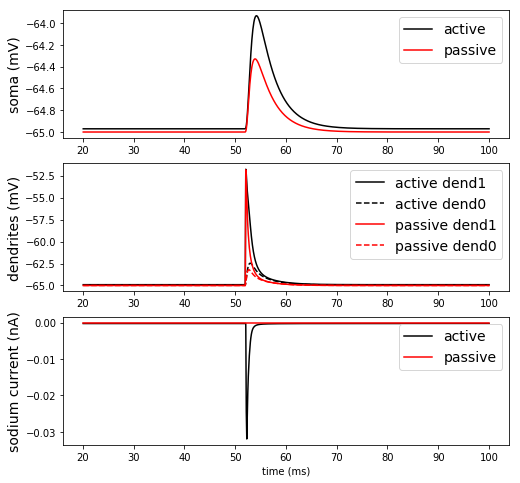

In [5]:
# record the necessary variables
vsoma_vec = h.Vector()         # Membrane potential vector
vdend1_vec = h.Vector()        # Membrane potential vector
vdend0_vec = h.Vector()        # Membrane potential vector
iNa_vec = h.Vector()           # Sodium current vector
t_vec = h.Vector()             # Time stamp vector
vsoma_vec.record(soma(0.5)._ref_v)
vdend1_vec.record(dend1(0.5)._ref_v)
vdend0_vec.record(dend0(0.5)._ref_v)
iNa_vec.record(dend1(0.5).traub._ref_iNa)
t_vec.record(h._ref_t)

# --------------------------------------------------------------------------------------------------------------
# STEP 1: Run the simulation WITH active conductances as defined above
# --------------------------------------------------------------------------------------------------------------

h.run()

# Remove the first 20 msec of the plot (to make it look nice)
vsoma_vec.remove(0,200)
vdend1_vec.remove(0,200)
vdend0_vec.remove(0,200)
iNa_vec.remove(0,200)
t_vec.remove(0,200)

# Plot results
plt.figure(figsize=(8,8)) # Default figsize is (8,6)
plt.subplot(3,1,1)
plt.plot(t_vec, vsoma_vec, color='black')
plt.subplot(3,1,2)
plt.plot(t_vec, vdend1_vec, color='black')
plt.plot(t_vec, vdend0_vec, '--',color='black')
plt.subplot(3,1,3)
plt.plot(t_vec, iNa_vec, color='black')

print ('Active case: somatic depolarization is ',  round(vsoma_vec.max()-vsoma_vec.min(),2), ' mV')
print ('Active case: distal dendritic depolarization is', round(vdend1_vec.max()-vdend1_vec.min(),2), 'mV')

# --------------------------------------------------------------------------------------------------------------
# STEP 2: Run the simulation WITHOUT active conductances by setting max conductances (gbar) to zero for Na and K
# --------------------------------------------------------------------------------------------------------------

# remove active conductances
for seg in dend1:
    seg.traub.gNabar = 0.0  # Sodium conductance in S/cm2
    seg.traub.gKbar = 0.0  # Potassium conductance in S/cm2

h.run()

# remove first 20 msec for plotting
vsoma_vec.remove(0,200)
vdend1_vec.remove(0,200)
vdend0_vec.remove(0,200)
iNa_vec.remove(0,200)
t_vec.remove(0,200)

# Plot the results
plt.subplot(3,1,1)
plt.plot(t_vec, vsoma_vec, color='red')
plt.legend(('active','passive'),fontsize=fs)
plt.ylabel('soma (mV)',fontsize=fs)
plt.subplot(3,1,2)
plt.plot(t_vec, vdend1_vec, color='red')
plt.plot(t_vec, vdend0_vec, '--',color='red')
plt.legend(('active dend1','active dend0','passive dend1','passive dend0'),fontsize=fs)
plt.ylabel('dendrites (mV)',fontsize=fs)
plt.subplot(3,1,3)
plt.plot(t_vec, iNa_vec, color='red')
plt.legend(('active','passive'),fontsize=fs)
plt.ylabel('sodium current (nA)',fontsize=fs)
plt.xlabel('time (ms)')
plt.ylabel('sodium current (nA)')

print ('Passive case: somatic depolarization is ',  round(vsoma_vec.max()-vsoma_vec.min(),2), ' mV')
print ('Passive case: distal dendritic depolarization is', round(vdend1_vec.max()-vdend1_vec.min(),2), 'mV')

### Task: follow the previous exercise and plot the expected versus actual somatic depolarization
### (Hint: it should be supra-linear!)